# Import

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import joblib
from sklearn.linear_model import LinearRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression,  RandomForestRegressor, GBTRegressor
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.model_selection import GridSearchCV
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split



# Start SparkSession

In [2]:
spark = SparkSession.builder.appName("StudentGPA").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/21 15:31:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Read Dataset from Hadoop

In [3]:
df = spark.read.csv("/DoAn/Raw_DataSet_3.csv", header=True, inferSchema=True)


# Linear Regression (7 semester's GPAs, No cross validation)

In [4]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = assembler.transform(df).select("features", "dtbhk_8")

train_df, test_df = data.randomSplit([0.8, 0.2], seed=40)

lr = LinearRegression(featuresCol="features", labelCol="dtbhk_8",
                      regParam=0.1, elasticNetParam=0.5)  
lr_model = lr.fit(train_df)
prediction = lr_model.transform(test_df)

prediction.select("features", "dtbhk_8", "prediction").show()


25/05/21 15:35:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+--------------------+-------+------------------+
|            features|dtbhk_8|        prediction|
+--------------------+-------+------------------+
|[1991.0,1.0,8.59,...|   8.59| 7.638753704628401|
|[1992.0,1.0,3.86,...|   4.94| 4.902887548224781|
|[1992.0,1.0,7.1,3...|   9.47| 7.543429719031682|
|[1992.0,1.0,7.22,...|   4.13| 6.680002932832172|
|[1992.0,1.0,7.34,...|   7.34|7.1569012396501535|
|[1992.0,1.0,8.03,...|   3.21| 5.823821206303082|
|[1993.0,1.0,4.41,...|   7.71| 7.358253219151459|
|[1993.0,1.0,5.92,...|   8.29| 7.094360938812871|
|[1993.0,1.0,6.16,...|   3.08|4.1283042331257125|
|[1994.0,0.0,6.49,...|   7.57| 8.131865134248635|
|[1994.0,0.0,7.25,...|   5.18| 5.510752779183472|
|[1994.0,1.0,2.15,...|   2.47|2.8919183832515962|
|[1994.0,1.0,2.31,...|   1.73|2.7759320016049136|
|[1994.0,1.0,3.27,...|   2.83| 2.877241808689188|
|[1994.0,1.0,4.99,...|   3.74| 8.497972034956272|
|[1994.0,1.0,5.53,...|   4.61| 5.681516751992769|
|[1994.0,1.0,5.58,...|   7.82|  6.49144758619059|


In [5]:
summary = lr_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)

RMSE: 1.0879338411866915
R2: 0.5856604940275647
MSE: 1.1836000427992293
MAE: 0.759024681367764


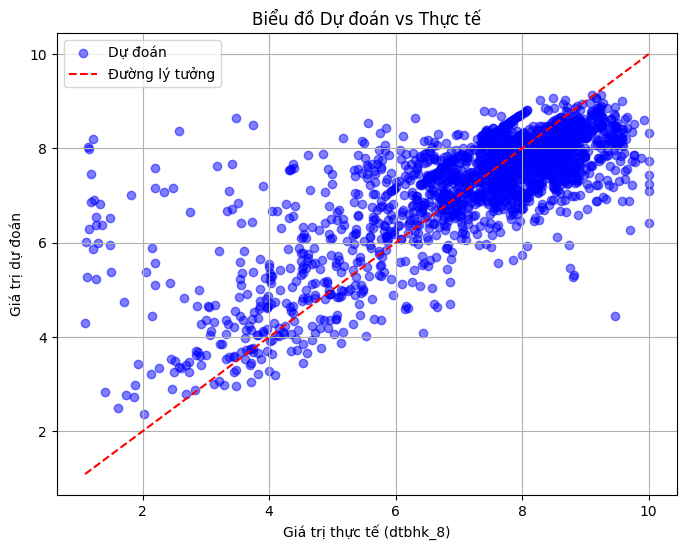

In [6]:
pred_df = prediction.select("dtbhk_8", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_8"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         [pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_8)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()


# Linear Regression with Cross validation ( 6 Semester GPA's )

Best regParam: 0.01
Best elasticNetParam: 0.3
+-------+------------------+
|dtbhk_7|        prediction|
+-------+------------------+
|   8.16| 7.933544042036194|
|   8.58| 8.798887305807366|
|   6.45| 8.163478604002968|
|   8.48| 7.829406370829813|
|    7.9| 8.528409869974464|
|   8.32| 8.011870272210738|
|   8.33| 7.872179947963897|
|   4.87|4.5221170006272615|
|   7.39| 6.585698407809493|
|   9.53| 8.181620264933782|
|   7.77|  8.31806215959815|
|   6.08| 4.385450485947181|
|   3.14| 4.346974271167248|
|   4.23|2.7598469182239804|
|   7.61| 7.848112182875264|
|   4.08| 4.389732807128875|
|   7.81| 8.487742180655154|
|    8.4| 8.075463474097715|
|   8.12| 8.398959204681205|
|    5.4| 4.473666969089501|
+-------+------------------+
only showing top 20 rows

RMSE: 1.0168802818246456
R2: 0.6161963820465775
MSE: 1.034045507563771
MAE: 0.6991253853692092


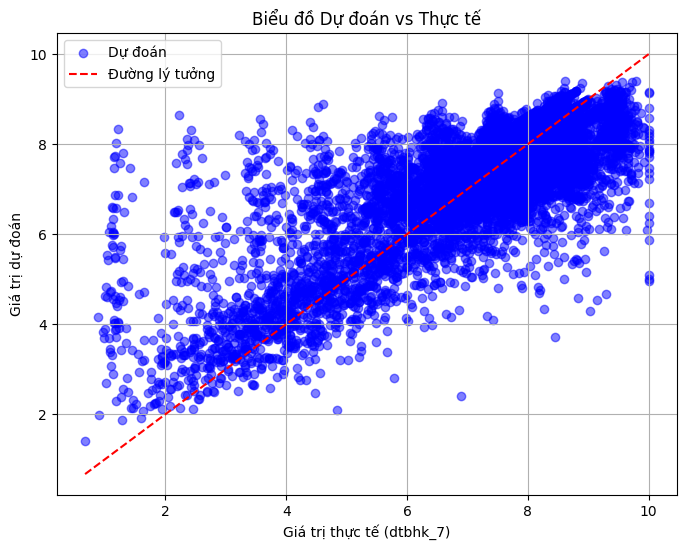

In [33]:
#6 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3', 'dtbhk_4', 'dtbhk_5', 'dtbhk_6']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_7")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_7",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_7", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_7", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
best_model.save("/spark_model/linear_logistic_6")
pred_df = predictions.select("dtbhk_7", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_7"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_7"].min(), pred_df["dtbhk_7"].max()],
         [pred_df["dtbhk_7"].min(), pred_df["dtbhk_7"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_7)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()


# Linear Regression with Cross validation ( 5 Semester GPA's )

In [34]:
#5 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3', 'dtbhk_4', 'dtbhk_5']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_6")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_6",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_6", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_6", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
best_model.save("/spark_model/linear_logistic_5")



Best regParam: 0.01
Best elasticNetParam: 0.3
+-------+------------------+
|dtbhk_6|        prediction|
+-------+------------------+
|   8.38| 7.391148878930576|
|   8.58| 8.847330546876144|
|    8.6| 7.712044309187739|
|   7.42| 8.072057234575176|
|   9.03| 8.474353039146514|
|   8.32|  7.99783111817122|
|   7.47| 8.290246792840922|
|   5.29|3.8546050321138345|
|   8.87|  4.12420852520545|
|   8.47| 8.240058909871607|
|   8.42| 8.189357487709287|
|   2.43| 5.225515605369946|
|   2.61| 5.251022718254447|
|   1.32| 3.383477039501365|
|   8.01| 7.663077873162358|
|    3.6| 4.586437877624586|
|   8.93| 7.978613324623353|
|    8.4| 7.962793803357506|
|   8.55| 8.355215842936719|
|   3.85| 4.350042618498616|
+-------+------------------+
only showing top 20 rows

RMSE: 1.005960513576395
R2: 0.6257913889458366
MSE: 1.0119565548748841
MAE: 0.6928060653518624


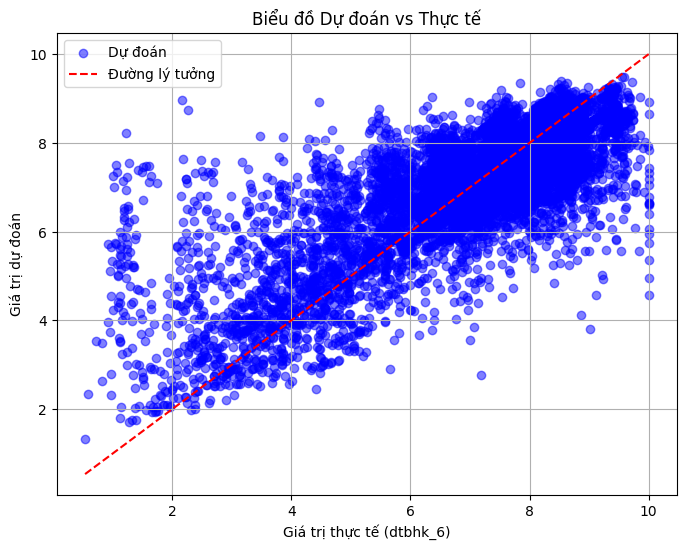

In [9]:
pred_df = predictions.select("dtbhk_6", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_6"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_6"].min(), pred_df["dtbhk_6"].max()],
         [pred_df["dtbhk_6"].min(), pred_df["dtbhk_6"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_6)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()

# Linear Regression with Cross validation ( 4 Semester GPA's )

In [35]:
#4 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3', 'dtbhk_4']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_5")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_5",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_5", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_5", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
best_model.save("/spark_model/linear_logistic_4")


Best regParam: 0.01
Best elasticNetParam: 0.0
+-------+------------------+
|dtbhk_5|        prediction|
+-------+------------------+
|   6.17| 7.963548613919087|
|   8.58| 8.938303445993213|
|   7.53|7.4208514129169885|
|   7.42| 8.384246379316679|
|   9.03| 7.822801756491032|
|   8.32|  7.55528232610466|
|   8.54| 7.870060268952159|
|   3.81|3.1651886312177453|
|   1.48| 6.196126024207814|
|   8.47| 7.821068099646496|
|   7.56| 8.440628937371145|
|   3.65| 6.102501693738688|
|   3.92| 5.964299085691877|
|   2.64| 3.634343247845507|
|   7.41| 7.623713135576324|
|    3.6| 4.914553198858627|
|    6.7| 8.728836483479029|
|    8.4| 7.551262894035105|
|   8.12|  8.31237983667394|
|   2.57| 5.419784534491541|
+-------+------------------+
only showing top 20 rows

RMSE: 1.0716231929898323
R2: 0.5757003789615295
MSE: 1.1483762677537235
MAE: 0.7444682194946926


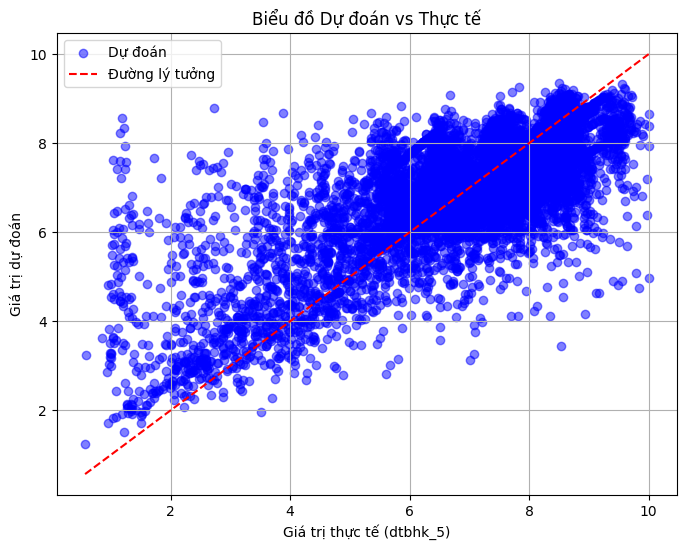

In [11]:
pred_df = predictions.select("dtbhk_5", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_5"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_5"].min(), pred_df["dtbhk_5"].max()],
         [pred_df["dtbhk_5"].min(), pred_df["dtbhk_5"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_5)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()

# Linear Regression with Cross validation ( 3 Semester GPA's )

In [36]:
#3 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_4")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_4",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_4", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_4", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
best_model.save("/spark_model/linear_logistic_3")


Best regParam: 0.01
Best elasticNetParam: 0.0
+-------+------------------+
|dtbhk_4|        prediction|
+-------+------------------+
|   8.16| 7.844174302646024|
|   8.58| 9.479357556610864|
|    8.6| 6.479294558847471|
|   8.48|  8.37115975090461|
|   7.45| 8.134718185388323|
|   7.28| 7.739220500407498|
|   8.54|  7.25875491391659|
|   1.06| 4.681707596607708|
|   4.44|7.6705443372385105|
|   7.41| 8.132694945333668|
|   8.64| 8.365499752813548|
|   6.08|6.0373738981613485|
|   5.23| 6.329549530429858|
|   2.11|  4.54480700025502|
|   7.81| 7.530972750921421|
|    3.6| 5.853486277100558|
|   8.93| 8.667458424245893|
|   7.35| 7.746785527306656|
|   8.34| 8.364282681047058|
|   5.14| 5.296040514483252|
+-------+------------------+
only showing top 20 rows

RMSE: 1.0296891912441204
R2: 0.585485601888639
MSE: 1.0602598305649706
MAE: 0.7238370312532135


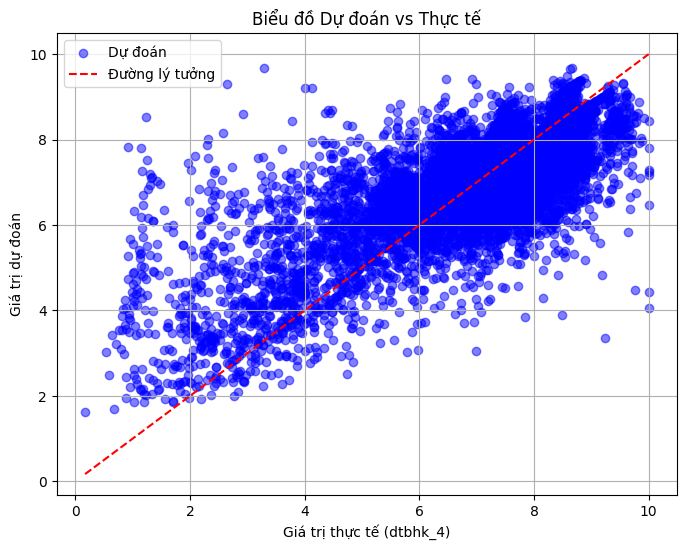

In [13]:
pred_df = predictions.select("dtbhk_4", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_4"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_4"].min(), pred_df["dtbhk_4"].max()],
         [pred_df["dtbhk_4"].min(), pred_df["dtbhk_4"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_4)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()

# Linear Regression with Cross validation ( 7 Semester GPA's )

In [37]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_8")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_8",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_8", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
best_model.save("/spark_model/linear_logistic_7")



Best regParam: 0.01
Best elasticNetParam: 0.0
+-------+------------------+
|dtbhk_8|        prediction|
+-------+------------------+
|   8.16|  7.96716733217572|
|   8.15|  8.71293478279381|
|   7.53| 7.601850904239418|
|   7.42| 8.051324634892374|
|   8.13|  8.23459936218835|
|   8.11| 8.076864417922444|
|   8.54| 8.106795821927662|
|   3.81| 4.844484589303983|
|   5.92| 6.273198202371507|
|   8.89| 8.659876162577456|
|   8.42| 8.052626323379263|
|   6.08| 5.236745390426826|
|   4.45| 4.044978806062721|
|   3.96|3.4597056903040464|
|   8.01| 7.734225369042493|
|   4.08| 4.397330385529818|
|   5.58| 8.104225082602417|
|    8.4| 8.068710036280216|
|   8.77| 8.239744651087802|
|   3.85|  4.78007861086815|
+-------+------------------+
only showing top 20 rows

RMSE: 1.084146695062276
R2: 0.5871938603270133
MSE: 1.175374056414456
MAE: 0.7507143271479054


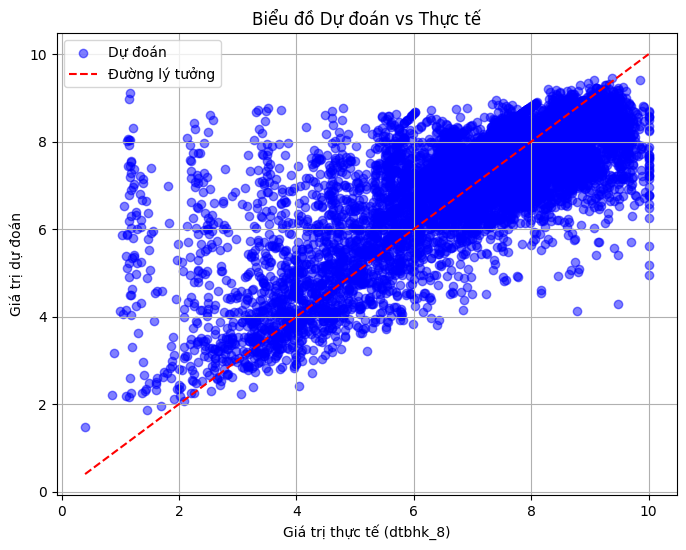

In [15]:
pred_df = predictions.select("dtbhk_8", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_8"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         [pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_8)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()

# Random Forest ( 6 Semester's GPA )

In [16]:
# 6 hoc ki
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4', 'dtbhk_5', 'dtbhk_6']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

# 
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_7")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_7", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_7", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
rmse = RegressionEvaluator(labelCol="dtbhk_7", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_7", predictionCol="prediction", metricName="mae").evaluate(predictions)
mse= RegressionEvaluator(labelCol="dtbhk_7", predictionCol="prediction", metricName="mse").evaluate(predictions)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_6")

RMSE: 1.053092568099193
R2: 0.6038250557814336
MSE: 1.1090039569857533
MAE: 0.7098541352563987


# Random Forest ( 5 Semester's GPA )

In [17]:
# 5 hoc ki
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4', 'dtbhk_5']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)


# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_6")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_6", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_6", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_6", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_6", predictionCol="prediction", metricName="mae").evaluate(predictions)
mse= RegressionEvaluator(labelCol="dtbhk_6", predictionCol="prediction", metricName="mse").evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_5")

RMSE: 1.0158628641896694
R2: 0.6270604389291208
MSE: 1.0319773588396386
MAE: 0.6830048431939727


# Random Forest ( 4 Semester's GPA )

In [18]:
# 4 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_5")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_5", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_5", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_5", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_5", predictionCol="prediction", metricName="mae").evaluate(predictions)
mse= RegressionEvaluator(labelCol="dtbhk_5", predictionCol="prediction", metricName="mse").evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_4")

RMSE: 1.038312727849863
R2: 0.6013840441157475
MSE: 1.0780933208150234
MAE: 0.718762173949562


# Random Forest ( 3 Semester's GPA )

In [19]:
# 3 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_4")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_4", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_4", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_4", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_4", predictionCol="prediction", metricName="mae").evaluate(predictions)
mse= RegressionEvaluator(labelCol="dtbhk_4", predictionCol="prediction", metricName="mse").evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_3")

RMSE: 1.0234244438987277
R2: 0.5986415266974953
MSE: 1.04739759236942
MAE: 0.7089498369636442


# Random Forest ( 7 Semester's GPA )

In [20]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_8")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_8", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="mae").evaluate(predictions)
mse= RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="mse").evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_7")


RMSE: 1.065467862844561
R2: 0.6090400673755421
MSE: 1.1352217667545563
MAE: 0.7457399526607567


# Gradient Boosted Tree

In [29]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = assembler.transform(df).select("features", "dtbhk_8")

train_df, test_df = data.randomSplit([0.8, 0.2], seed=40)

gbt = GBTRegressor(featuresCol="features", labelCol="dtbhk_8", maxIter=100)
gbt_model = gbt.fit(train_df)
gbt_prediction = gbt_model.transform(test_df)

gbt_prediction.select("features", "dtbhk_8", "prediction").show()
evaluator = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(gbt_prediction)

rmse = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="rmse").evaluate(gbt_prediction)
mae = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="mae").evaluate(gbt_prediction)

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")



+--------------------+-------+------------------+
|            features|dtbhk_8|        prediction|
+--------------------+-------+------------------+
|[0.0,-1.0,1.75,3....|   6.38| 5.448879413654358|
|[0.0,-1.0,1.92,3....|   4.97| 5.014327986203086|
|[0.0,-1.0,2.39,3....|   4.44| 4.254420094901856|
|[0.0,-1.0,2.45,0....|   5.06| 5.410129376578747|
|[0.0,-1.0,2.46,2....|   3.12|  5.13412123540393|
|[0.0,-1.0,2.51,1....|    5.6| 5.478771965147534|
|[0.0,-1.0,2.67,1....|   4.44| 4.197727224224477|
|[0.0,-1.0,2.91,6....|   6.57|7.1894002518602536|
|[0.0,-1.0,2.94,2....|   3.42|3.6088704802075817|
|[0.0,-1.0,3.53,3....|   4.65|3.4987050176393746|
|[0.0,-1.0,3.53,3....|    5.0|  6.05017411252384|
|[0.0,-1.0,3.64,3....|    2.1|3.2698790337523134|
|[0.0,-1.0,3.71,2....|   6.45| 6.867580297370542|
|[0.0,-1.0,3.73,4....|   2.02|2.9371397806438515|
|[0.0,-1.0,4.0,1.6...|   3.51|3.0533650546121236|
|[0.0,-1.0,4.12,2....|   7.15| 6.521005748908099|
|[0.0,-1.0,4.12,3....|   5.05| 2.975704799146808|


# XGboost (7 Semester's GPA )

RMSE:  1.050142513843597
R2 score: 0.6199194791917069
MSE:  1.102799299381749
MAE:  0.7002989456691305


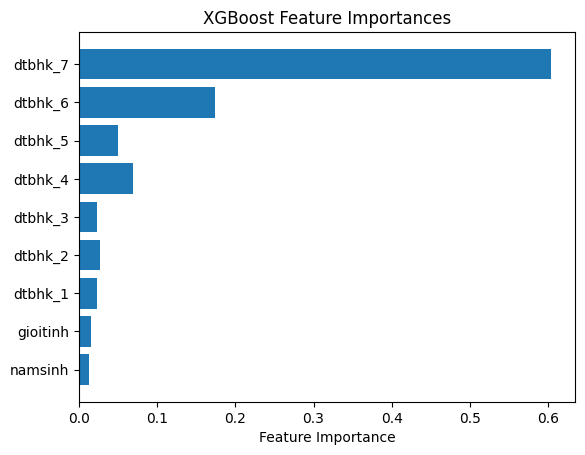

Luu thanh cong


In [28]:

pdf = df.toPandas()  # convert từ PySpark về Pandas

X = pdf[['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']]
y = pdf['dtbhk_8']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))
print("MSE: " , mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()
try:
    joblib.dump(model, "./saved_model/xgboost_7.pkl")
    print("Luu thanh cong")
except Exception as e:
    print("Luu loi")



# XGboost (6 Semester's GPA )

RMSE:  1.0526497170021376
R2 score: 0.6055044967545239
MSE:  1.1080714267046805
MAE:  0.7105539739571891


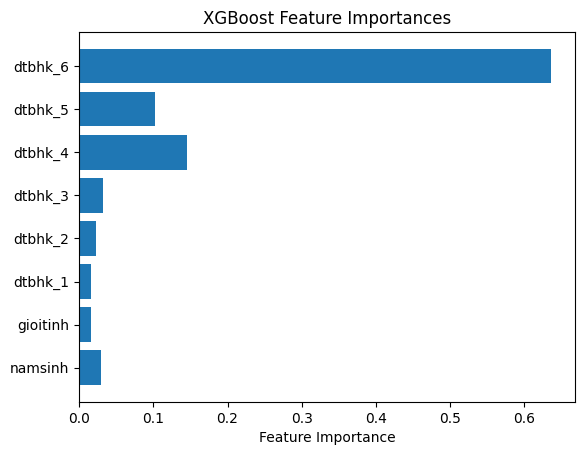

Luu thanh cong


In [29]:
pdf = df.toPandas()  # convert từ PySpark về Pandas

X = pdf[['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6']]
y = pdf['dtbhk_7']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))
print("MSE: " , mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()
try:
    joblib.dump(model, "./saved_model/xgboost_6.pkl")
    print("Luu thanh cong")
except Exception as e:
    print("Luu loi")


# XGboost (5 Semester's GPA )

RMSE:  0.9500014121733775
R2 score: 0.6639189937804117
MSE:  0.9025026831314116
MAE:  0.6455960218034854


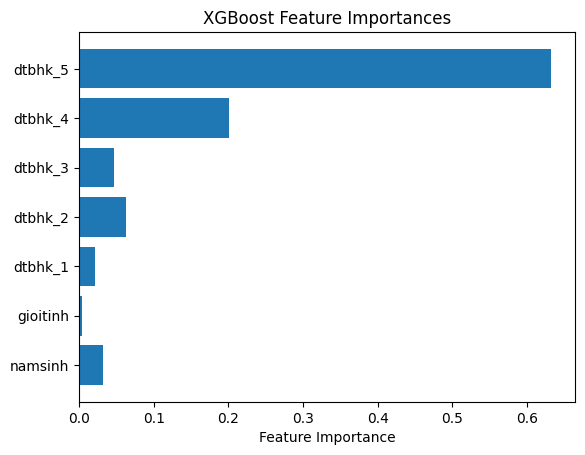

Luu thanh cong


In [30]:
pdf = df.toPandas()  # convert từ PySpark về Pandas

X = pdf[['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5']]
y = pdf['dtbhk_6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))
print("MSE: " , mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()
try:
    joblib.dump(model, "./saved_model/xgboost_5.pkl")
    print("Luu thanh cong")
except Exception as e:
    print("Luu loi")


# XGboost (4 Semester's GPA )

RMSE:  1.0041438499567272
R2 score: 0.6204327315160205
MSE:  1.0083048714059182
MAE:  0.6958664510602063


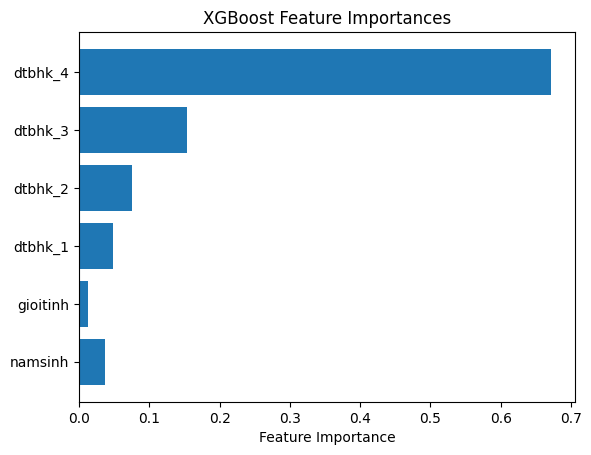

Luu thanh cong


In [31]:
pdf = df.toPandas()  # convert từ PySpark về Pandas

X = pdf[['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4']]
y = pdf['dtbhk_5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))
print("MSE: " , mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()
try:
    joblib.dump(model, "./saved_model/xgboost_4.pkl")
    print("Luu thanh cong")
except Exception as e:
    print("Luu loi")


# XGBoost ( 3 semester )

RMSE:  1.0624211052462624
R2 score: 0.5852613540247
MSE:  1.12873860487269
MAE:  0.7263734599764611


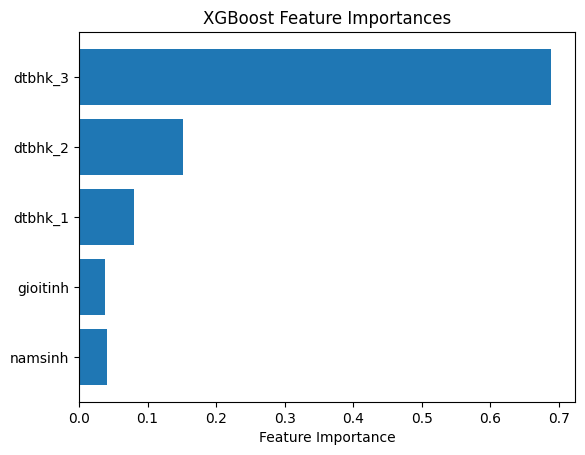

Luu thanh cong


In [32]:
pdf = df.toPandas()  # convert từ PySpark về Pandas

X = pdf[['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3']]
y = pdf['dtbhk_4']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))
print("MSE: " , mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()
try:
    joblib.dump(model, "./saved_model/xgboost_3.pkl")
    print("Luu thanh cong")
except Exception as e:
    print("Luu loi")
